# Example Notebook

Welcome to the example notebook for the Home Credit Kaggle competition. The goal of this competition is to determine how likely a customer is going to default on an issued loan. The main difference between the [first](https://www.kaggle.com/c/home-credit-default-risk) and this competition is that now your submission will be scored with a custom metric that will take into account how well the model performs in future. A decline in performance will be penalized. The goal is to create a model that is stable and performs well in the future.

In this notebook you will see how to:
* Load the data
* Join tables with Polars - a DataFrame library implemented in Rust language, designed to be blazingy fast and memory efficient.  
* Create simple aggregation features
* Train a LightGBM model
* Create a submission table

## Load the data

In [38]:
!pip install polars
!pip install pyarrow
!pip install CatBoost
!pip install phik
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.1 MB/s eta 0:00:00a 0:00:01


In [39]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import polars as pl
import seaborn as sns

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score 

dataPath = "/Users/vs/Programming/Data Science/Kaggle/1. home credit 2024/"
RANDOM_STATE = 40324

In [3]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [4]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [5]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

## Feature engineering

In this part, we can see a simple example of joining tables via `case_id`. Here the loading and joining is done with polars library. Polars library is blazingly fast and has much smaller memory footprint than pandas. 

In [6]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or 
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [7]:
del train_person_1
del train_credit_bureau_b_2
del train_basetable
del train_static
del train_static_cb
del train_person_1_feats_1
del train_person_1_feats_2
del train_credit_bureau_b_2_feats

In [8]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [9]:
del test_person_1
del test_credit_bureau_b_2
del test_basetable
del test_static
del test_static_cb
del test_person_1_feats_1
del test_person_1_feats_2
del test_credit_bureau_b_2_feats

In [10]:
case_ids = data["case_id"].unique().shuffle(seed=RANDOM_STATE)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=RANDOM_STATE)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=RANDOM_STATE)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [11]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (915995, 48)
Valid: (305332, 48)
Test: (305332, 48)


## Column data

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915995 entries, 0 to 915994
Data columns (total 48 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   amtinstpaidbefduel24m_4187115A   579292 non-null  float64 
 1   annuity_780A                     915995 non-null  float64 
 2   annuitynextmonth_57A             915993 non-null  float64 
 3   avginstallast24m_3658937A        541370 non-null  float64 
 4   avglnamtstart24m_4525187A        97623 non-null   float64 
 5   avgoutstandbalancel6m_4187114A   411545 non-null  float64 
 6   avgpmtlast12m_4525200A           300125 non-null  float64 
 7   credamount_770A                  915995 non-null  float64 
 8   currdebt_22A                     915993 non-null  float64 
 9   currdebtcredtyperange_828A       915993 non-null  float64 
 10  disbursedcredamount_1113A        915995 non-null  float64 
 11  downpmt_116A                     915995 non-null  fl

In [59]:
X_train.describe()

,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,...,price_1097A,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A
count,5.792920e+05,915995.000000,915993.000000,541370.000000,97623.000000,4.115450e+05,300125.000000,915995.000000,9.159930e+05,9.159930e+05,...,782191.000000,6.489570e+05,4.117070e+05,9.159930e+05,9.159930e+05,211726.000000,85889.000000,69005.000000,43210.00000,343810.000000
mean,5.591278e+04,4037.053979,1438.215890,5393.635247,44658.488032,4.595938e+04,6389.822316,49879.950127,1.970342e+04,1.100286e+04,...,34459.666967,2.770214e+04,2.832341e+04,1.970405e+04,9.230859e+04,10365.050559,9292.380057,10040.529823,17648.63806,13165.647983
std,7.154372e+04,3003.026916,2808.628884,6523.567317,44769.567665,6.435128e+04,9095.306652,44180.420010,5.083716e+04,3.676071e+04,...,34465.692478,5.839549e+04,6.046442e+04,5.083804e+04,1.695881e+05,16103.890181,5541.700221,5437.126187,6834.67670,18046.574587
min,0.000000e+00,80.800000,0.000000,0.000000,0.000000,-7.588198e+06,0.000000,2000.000000,0.000000e+00,0.000000e+00,...,0.000000,-2.504400e+04,-2.504400e+04,0.000000e+00,0.000000e+00,0.214000,0.000000,4.200000,4.40000,0.000000
25%,7.419600e+03,1967.200100,0.000000,2524.400100,15718.601000,8.696532e+03,2588.400100,19998.000000,0.000000e+00,0.000000e+00,...,13800.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3310.887500,6589.800300,7192.200000,13641.60100,3135.850000
50%,2.973411e+04,3150.400100,0.000000,4065.400100,28419.400000,2.272751e+04,4419.000000,35200.000000,0.000000e+00,0.000000e+00,...,25172.000000,0.000000e+00,0.000000e+00,0.000000e+00,3.598000e+04,6218.100000,7292.500000,7553.000000,15764.00000,8398.026500
75%,7.631142e+04,5230.800300,2041.200100,6545.600000,56309.101000,5.539809e+04,7512.600000,63994.000000,1.355800e+04,0.000000e+00,...,45348.902000,2.799800e+04,2.799800e+04,1.355920e+04,1.189040e+05,11658.000000,13000.601000,13464.400000,21808.85025,16980.967250
max,1.408010e+06,106007.000000,87500.000000,496148.800000,513520.000000,1.128721e+06,400000.000000,950000.000000,1.092393e+06,1.028338e+06,...,761867.440000,1.092393e+06,1.071761e+06,1.092393e+06,4.803504e+07,794899.200000,127760.200000,205848.610000,99012.80500,459898.250000


In [14]:
X_train.phik_matrix()

interval columns not set, guessing: ['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcredamount_781A', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcredamount_222A', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallast1m_4525188A', 'pmtaverage_3A', 'pmtaverage_4527227A', 'pmtaverage_4955615A', 'pmtssum_45A']


,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,...,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A
amtinstpaidbefduel24m_4187115A,1.000000,0.097903,0.400811,0.064396,0.410251,0.247129,0.152812,0.141111,0.372598,0.319637,...,0.409459,0.085259,0.060241,0.005745,0.090972,0.010660,0.099695,0.000000,0.097504,0.050918
annuity_780A,0.097903,1.000000,0.067197,0.022040,0.084619,0.000000,0.042931,0.417986,0.004930,0.019233,...,0.043183,0.050996,0.029056,0.000000,0.027345,0.000000,0.130712,0.032014,0.108927,0.092014
annuitynextmonth_57A,0.400811,0.067197,1.000000,0.030477,0.507858,0.360043,0.045183,0.068513,0.496168,0.369662,...,0.041564,0.036652,0.046728,0.052142,0.058205,0.019552,0.112550,0.000000,0.079417,0.053746
avginstallast24m_3658937A,0.064396,0.022040,0.030477,1.000000,0.170405,0.000000,0.883698,0.033778,0.005003,0.000000,...,0.256338,0.012835,0.005692,0.000000,0.009756,0.000000,0.026622,0.000000,0.000000,0.031622
avglnamtstart24m_4525187A,0.410251,0.084619,0.507858,0.170405,1.000000,0.505645,0.211951,0.137006,0.664124,0.613590,...,0.393503,0.026999,0.060473,0.006901,0.062320,0.008054,0.000000,0.000000,0.017405,0.106041
avgoutstandbalancel6m_4187114A,0.247129,0.000000,0.360043,0.000000,0.505645,1.000000,0.008241,0.042664,0.677518,0.556770,...,0.047813,0.039986,0.054975,0.004258,0.044643,0.006794,0.009657,0.006662,0.007172,0.000000
avgpmtlast12m_4525200A,0.152812,0.042931,0.045183,0.883698,0.211951,0.008241,1.000000,0.057423,0.015613,0.007000,...,0.384556,0.021108,0.017992,0.008185,0.020946,0.000000,0.000000,0.000000,0.000000,0.000000
credamount_770A,0.141111,0.417986,0.068513,0.033778,0.137006,0.042664,0.057423,1.000000,0.062504,0.102450,...,0.073079,0.053849,0.042269,0.000000,0.053731,0.002457,0.039043,0.041902,0.062132,0.102657
currdebt_22A,0.372598,0.004930,0.496168,0.005003,0.664124,0.677518,0.015613,0.062504,1.000000,0.893939,...,0.013584,0.034933,0.063277,0.012828,0.089039,0.014817,0.017922,0.011948,0.020982,0.013518
currdebtcredtyperange_828A,0.319637,0.019233,0.369662,0.000000,0.613590,0.556770,0.007000,0.102450,0.893939,1.000000,...,0.007564,0.021302,0.051547,0.010187,0.072718,0.010679,0.012630,0.004048,0.017757,0.016180


In [75]:
feature_definitions = pd.read_csv(dataPath + 'feature_definitions.csv')
feature_definitions_df = pd.DataFrame(feature_definitions)
X_train_df = pd.DataFrame(X_train)

column_description = {}

for variable, description in zip(feature_definitions_df['Variable'], feature_definitions_df['Description']):
    if variable in X_train_df.columns:
        column_description[variable] = description

print(column_description)

{'amtinstpaidbefduel24m_4187115A': 'Number of instalments paid before due date in the last 24 months.', 'annuity_780A': 'Monthly annuity amount.', 'annuitynextmonth_57A': "Next month's amount of annuity.", 'avginstallast24m_3658937A': 'Average instalments paid by the client over the past 24 months.', 'avglnamtstart24m_4525187A': 'Average loan amount in the last 24 months.', 'avgoutstandbalancel6m_4187114A': 'Average outstanding balance of applicant for the last 6 months.', 'avgpmtlast12m_4525200A': 'Average of payments made by the client in the last 12 months.', 'credamount_770A': 'Loan amount or credit card limit.', 'currdebt_22A': 'Current debt amount of the client.', 'currdebtcredtyperange_828A': 'Current amount of debt of the applicant.', 'description_5085714M': 'Categorization of clients by credit bureau.', 'disbursedcredamount_1113A': 'Disbursed credit amount after consolidation.', 'downpmt_116A': 'Amount of downpayment.', 'education_1103M': 'Level of education of the client prov

In [76]:
def get_boxplot(column):

    data = {
        'Х_train': [],
        'Х_valid': [],
        'Х_test': []
    }


    an_df = pd.DataFrame(data)

    an_df['Х_train'] = X_train[column]
    an_df['Х_valid'] = X_valid[column]
    an_df['Х_test'] = X_test[column]

    plt.figure(figsize=(15, 5))
    sns.boxplot(data=an_df, orient='h', palette='Set1')
    plt.title(column_description[column])
    plt.ylabel('Table')
    plt.show()

### amtinstpaidbefduel24m_4187115A
Number of instalments paid before due date in the last 24 months.

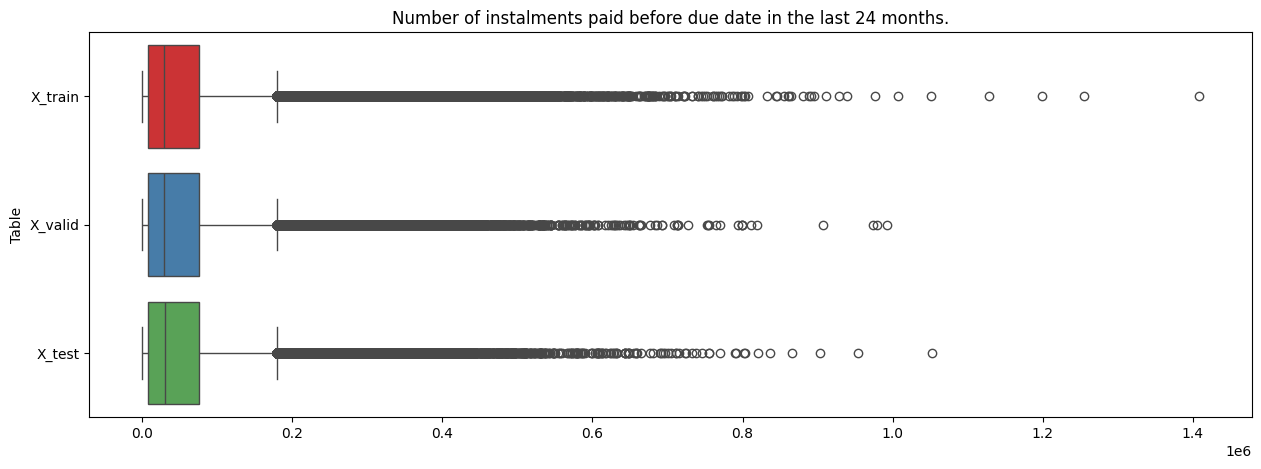

In [77]:
get_boxplot('amtinstpaidbefduel24m_4187115A')

## Data optimization

## Training LightGBM

Minimal example of LightGBM training is shown below.

In [16]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10)]
)

/Users/vs/anaconda3/envs/home-credit-2024/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.700905
[100]	valid_0's auc: 0.718211
[150]	valid_0's auc: 0.725839
[200]	valid_0's auc: 0.73062
[250]	valid_0's auc: 0.733876
[300]	valid_0's auc: 0.736963
[350]	valid_0's auc: 0.738788
[400]	valid_0's auc: 0.740651
[450]	valid_0's auc: 0.741778
[500]	valid_0's auc: 0.743153
[550]	valid_0's auc: 0.744274
[600]	valid_0's auc: 0.745208
[650]	valid_0's auc: 0.746025
[700]	valid_0's auc: 0.746795
[750]	valid_0's auc: 0.747634
[800]	valid_0's auc: 0.748346
[850]	valid_0's auc: 0.748798
[900]	valid_0's auc: 0.749222
Early stopping, best iteration is:
[890]	valid_0's auc: 0.749232


Evaluation with AUC and then comparison with the stability metric is shown below.

In [17]:
for base, X in [(base_train, X_train), (base_valid, X_valid), (base_test, X_test)]:
    y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)
    base["score"] = y_pred

print(f'The AUC score on the train set is: {roc_auc_score(base_train["target"], base_train["score"])}') 
print(f'The AUC score on the valid set is: {roc_auc_score(base_valid["target"], base_valid["score"])}') 
print(f'The AUC score on the test set is: {roc_auc_score(base_test["target"], base_test["score"])}')  

The AUC score on the train set is: 0.7684320366883126
The AUC score on the valid set is: 0.7492316317568893
The AUC score on the test set is: 0.752255395862036


In [18]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)
stability_score_test = gini_stability(base_test)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 
print(f'The stability score on the test set is: {stability_score_test}')  

The stability score on the train set is: 0.5118108585063198
The stability score on the valid set is: 0.4609133480205614
The stability score on the test set is: 0.43951460419556865


## Submission

Scoring the submission dataset is below, we need to take care of new categories. Then we save the score as a last step. 

In [19]:
X_submission = data_submission[cols_pred].to_pandas()
X_submission = convert_strings(X_submission)
categorical_cols = X_train.select_dtypes(include=['category']).columns

for col in categorical_cols:
    train_categories = set(X_train[col].cat.categories)
    submission_categories = set(X_submission[col].cat.categories)
    new_categories = submission_categories - train_categories
    X_submission.loc[X_submission[col].isin(new_categories), col] = "Unknown"
    new_dtype = pd.CategoricalDtype(categories=train_categories, ordered=True)
    X_train[col] = X_train[col].astype(new_dtype)
    X_submission[col] = X_submission[col].astype(new_dtype)

y_submission_pred = gbm.predict(X_submission, num_iteration=gbm.best_iteration)

In [20]:
submission = pd.DataFrame({
    "case_id": data_submission["case_id"].to_numpy(),
    "score": y_submission_pred
}).set_index('case_id')
submission.to_csv("./submission.csv")